# GAE, VGAE
参考  
- https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=vgae#torch_geometric.nn.models.VGAE  
- https://www.mattari-benkyo-note.com/2022/05/23/pytorch-geometric-vgae/  
- グラフニューラルネットワーク　PyTorch による実装　村田剛志


In [2]:
# Install required packages.
import os
import torch
import numpy as np
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cpu


In [3]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), 
                     with_labels=False, node_color=color, cmap='Set2')
    plt.show()

def visualize_embedding(h: torch.Tensor, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:,0], h[:,1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

karate club データをダウンロード

In [4]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [5]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges/data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self loops: False
Is undirected: True


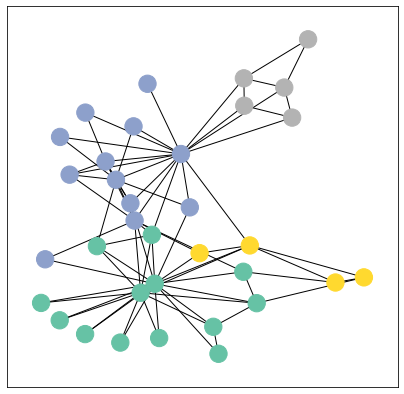

In [6]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

VGAE を作成。VGAE は encoder を代入して利用するモジュール。

In [7]:
import torch
from torch_geometric.nn import GCNConv, VGAE

class VGAE_Encoder(torch.nn.Module):
    def __init__(self, mid_channels, out_channels):
        super(VGAE_Encoder, self).__init__()
        torch.manual_seed(1234)
        self.gcn0 = GCNConv(dataset.num_features, mid_channels)
        self.conv_mu = GCNConv(mid_channels, out_channels)
        self.conv_logstd = GCNConv(mid_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.gcn0(x, edge_index).relu()

        return self.conv_mu(h, edge_index), self.conv_logstd(h, edge_index)

model = VGAE(VGAE_Encoder(4, 2))
print(model)

VGAE(
  (encoder): VGAE_Encoder(
    (gcn0): GCNConv(34, 4)
    (conv_mu): GCNConv(4, 2)
    (conv_logstd): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)


2次元に埋め込み（学習なし）

Embedding shape: [34, 2]


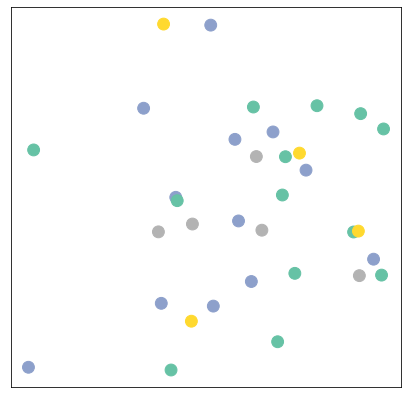

In [8]:
model = VGAE(VGAE_Encoder(4, 2))

z = model.encode(data.x, data.edge_index)
print(f'Embedding shape: {list(z.shape)}')
visualize_embedding(z, color=data.y)

2次元に埋め込み（学習あり）

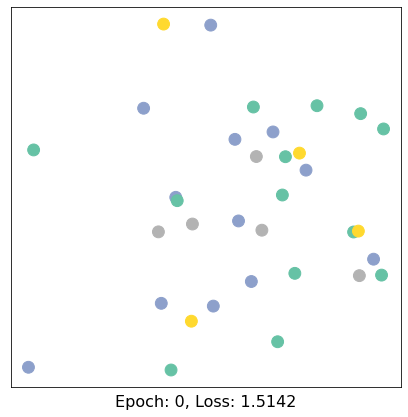

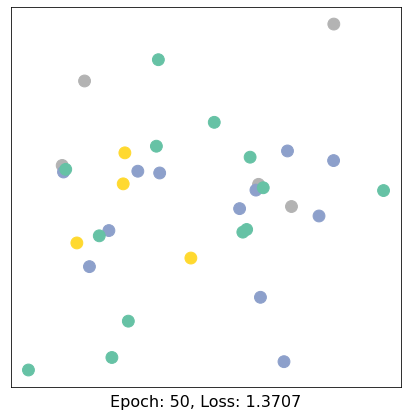

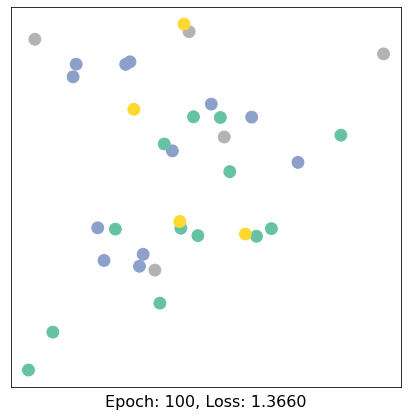

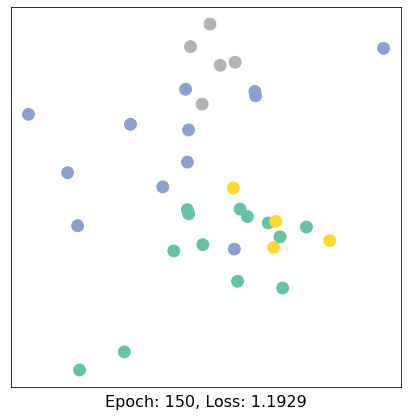

In [9]:
import time

model = VGAE(VGAE_Encoder(4, 2))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

for epoch in range(0, 200):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    recon_loss = model.recon_loss(z, data.edge_index)
    kl_loss = (1 / data.num_nodes) * model.kl_loss()
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        visualize_embedding(z, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

潜在ベクトルの次元を4に増やし、復号まで実行してみる。

In [10]:
model = VGAE(VGAE_Encoder(4, 4))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(0, 200):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    recon_loss = model.recon_loss(z, data.edge_index)
    kl_loss = (1 / data.num_nodes) * model.kl_loss()
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()


a = model.decode(z, data.edge_index)

ノードの組が閾値以上のスコアをもつならば、枝を張る

In [11]:
all_nodes = np.array(range(data.num_nodes))
all_edges = np.array([[[u, v] for v in all_nodes if u != v] for u in all_nodes]).reshape([-1, 2])
all_edges = torch.from_numpy(all_edges).t().contiguous()
all_edges = all_edges.to(torch.long)
print(all_edges)

thr = 0.7
a = model.decode(z, all_edges)
edges = all_edges.t()[a > thr].t()

tensor([[ 0,  0,  0,  ..., 33, 33, 33],
        [ 1,  2,  3,  ..., 30, 31, 32]])


Cora に適用

In [12]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')
print(len(dataset))
print(dataset[0])
print(dataset[0].num_nodes)
print(dataset[0].is_undirected())
print(dataset.num_classes)
print(dataset.num_node_features)

Cora_data = dataset[0]

1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
2708
True
7
1433


枝の一部を取り除いて、それが復元できるか検証  
- edge_train_mask
  - 枝の一部を取り除くマスク。90%
- edge_removed_mask
  - edge_train_mask の反転。10%
- test_edge_index
  - テストに使う枝。取り除かれた枝と、もともと接続していなかった枝（ノードの組）の両方を含む。10%

In [169]:
def mask_edge_index(edge_index:torch.Tensor, mask:torch.Tensor):
    return torch.reshape(edge_index[mask], [2,-1])

def remove_undirected_edge(edge_index:torch.Tensor, edges:torch.Tensor):
    num_edges = edge_index.size()[1]
    if edges.size() == torch.Size([2]):
        edges = torch.reshape(edges, [2,-1])

    mask = [True]*num_edges
    for i in range(edges.size()[1]):
        e = edges[:,i]
        for j in range(num_edges):
            if torch.allclose(edge_index[:,j], e):
                mask[j] = False
                break
        for j in range(num_edges):
            if torch.allclose(edge_index[:,j], e.flip(dims=[0])):
                mask[j] = False
                break

    mask = torch.reshape(torch.tensor(mask*2), edge_index.size())

    return mask_edge_index(edge_index, mask), mask   

def add_undirected_edge(edge_index:torch.Tensor, edges:torch.Tensor):
    if edges.size() == torch.Size([2]):
        edges = torch.reshape(edges, [2,-1])

    return torch.cat([edge_index, edges], dim=1)

def rev_edge_index(edge_index:torch.Tensor, due_idx:int):
    rev_edge = edge_index[:,due_idx].flip(dims=[0])

    for j in range(edge_index.size()[1]):
        if torch.allclose(edge_index[:,j], rev_edge):
            return j

    return None


def make_edge_train_mask(edge_index:torch.Tensor, num_removed:int):
    num_edges = edge_index.size()[1]

    edge_train_mask = [True]*num_edges
    tmp_idx = list(range(num_edges))
    for i in range(int(num_removed/2)):
        due_idx = np.random.choice(tmp_idx)
        rev_idx = rev_edge_index(edge_index, due_idx)

        for idx in [due_idx, rev_idx]:
            edge_train_mask[idx] = False
            tmp_idx.remove(idx)

    edge_train_mask = torch.reshape(torch.tensor(edge_train_mask*2), [2,-1])

    return edge_train_mask

def make_negative_edge_index(edge_index:torch.Tensor, num_negative:int):
    num_edges = edge_index.size()[1]
    negative_edge_index = np.array([[-1,-1]])
    max_index = edge_index.max().item()

    for i in range(int(num_negative/2)):
        # print(i)
        while True :
            negative_edge = np.random.choice(range(max_index+1), 2, replace=False)

            flag = False
            for edge in negative_edge_index:
                if np.allclose(edge, negative_edge):
                    flag = True
                    break
            if flag :
                continue
            
            for j in range(num_edges):
                if np.allclose(edge_index[:,j], negative_edge):
                    flag = True
                    break
            if flag :
                continue

            negative_edge_index = np.concatenate([negative_edge_index, negative_edge.reshape([1,2])], axis=0)
            negative_edge_index = np.concatenate([negative_edge_index, np.flip(negative_edge,axis=0).reshape([1,2])], axis=0)
            break
    
    negative_edge_index = np.delete(negative_edge_index, 0, axis=0)
    negative_edge_index = torch.from_numpy(negative_edge_index.T).to(dtype=edge_index.dtype)
    return negative_edge_index


In [172]:
rate = 0.02
num_removed = int(Cora_data.num_edges*rate/2)*2
edge_train_mask = make_edge_train_mask(Cora_data.edge_index, num_removed)
edge_removed_mask = torch.from_numpy(np.logical_not(edge_train_mask.numpy()))
print(f'all edges : {Cora_data.num_edges}\n' + 
      f'train     : {sum(edge_train_mask[0])}\n' +
      f'removed   : {sum(edge_removed_mask[0])}')

all edges : 10556
train     : 10346
removed   : 210


In [170]:
num_negative = num_removed
negative_edge_index = make_negative_edge_index(Cora_data.edge_index, num_negative)
negative_edge_index

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


tensor([[ 630,  402,  996, 1487, 1082, 2309,  118, 2704, 2586, 1279, 1047,  476,
         1998, 1108, 2589, 1160, 1701, 1098, 2081,  540, 1216,  637,  636, 2655,
          771, 2535, 1763, 1245, 1018, 1995,  712,   63, 1084, 2254, 1478,  917,
         1594,  828, 1279, 1529, 2320, 2078, 2411, 2070, 1396, 2471, 2611,  621,
          922,   25, 1562, 1401, 2512, 1435, 2116, 1043, 1665,  542,  174, 1170,
         2047, 2005, 1027, 1717, 2135, 2665,  341,   78, 1253, 2387, 2680,   52,
         2564, 1359, 2168, 2213, 1077, 1434, 1109,  843, 2359,  422,  918,  662,
           28, 2391, 1705, 1687, 1492,  234,  554, 2390, 1764, 2341,   45, 1066,
          317, 1562, 2437,  669,  504, 1530, 1519,   30, 1915, 1880, 1804, 2239,
         1270,  867,  544, 1080, 1952, 2238,  966, 1939, 1731, 2397, 2402, 1989,
         2617,  847, 1824, 1035,  287,  492, 1731, 1835,  746, 2377,  959, 1667,
         1595,  943,  198, 2396, 2162, 1313,  609,  391,   67, 2421,  951, 1985,
         1374,  911, 1642,  

In [97]:
np.allclose([1,2], torch.tensor([1,2]))

True

In [19]:
from torch_geometric.utils import dropout_edge
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3],
                           [1, 0, 2, 1, 3, 2]])
edge_index, edge_mask = dropout_edge(edge_index, p=0.5, force_undirected=True)
print(edge_index)
print(edge_mask)


tensor([[0, 1, 1, 2],
        [1, 2, 0, 1]])
tensor([0, 2, 0, 2])


In [138]:
Cora_data.edge_index.dtype

torch.int64

In [162]:
a = np.array([[0,1],[2,3]])
b = np.array([5,5])
s = set()
for item in b:
    s.add(item)
s

{5}

In [168]:
np.random.choice(list({2,3}), 2, replace=False)

array([3, 2])